In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GRU, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

In [2]:
# Load preprocessed data
# Assuming X_jma and y_jma are already preprocessed
import numpy as np
X_jma = np.load("X_jma_cnn_bilstm.npy")
y_jma = np.load("y_jma_cnn_bilstm.npy", allow_pickle=True)

# Verify the shape
print(f"X_jma shape: {X_jma.shape}")
print(f"y_jma shape: {y_jma.shape}")


X_jma shape: (85330, 5, 10)
y_jma shape: (85330, 1)


In [17]:
from sklearn.model_selection import train_test_split

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_jma, y_jma, test_size=0.2, random_state=42)

In [18]:
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_test shape: (17066, 5, 10)
y_test shape: (17066, 1)


In [20]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv1D, MaxPooling1D, BatchNormalization,
                                     Bidirectional, LSTM, Dense, Dropout, Attention)

# Input layer
input_layer = Input(shape=(X_jma.shape[1], X_jma.shape[2]))  # (timesteps, features)

# Feature Extraction Block
conv1 = Conv1D(filters=16, kernel_size=5, strides=1, activation='relu', padding='same')(input_layer)
bn1 = BatchNormalization()(conv1)
pool1 = MaxPooling1D(pool_size=2, strides=2, padding='same')(bn1)

conv2 = Conv1D(filters=32, kernel_size=3, strides=1, activation='relu', padding='same')(pool1)
bn2 = BatchNormalization()(conv2)
pool2 = MaxPooling1D(pool_size=2, strides=2, padding='same')(bn2)

conv3 = Conv1D(filters=64, kernel_size=3, strides=1, activation='relu', padding='same')(pool2)
bn3 = BatchNormalization()(conv3)
pool3 = MaxPooling1D(pool_size=2, strides=2, padding='same')(bn3)

conv4 = Conv1D(filters=128, kernel_size=3, strides=1, activation='relu', padding='same')(pool3)
bn4 = BatchNormalization()(conv4)
pool4 = MaxPooling1D(pool_size=2, strides=2, padding='same')(bn4)

# Reshape is not required as pool4's output shape is already compatible with LSTM
# Sequence Learning Block
lstm1 = Bidirectional(LSTM(units=128, return_sequences=True))(pool4)
dropout1 = Dropout(rate=0.2)(lstm1)
lstm2 = Bidirectional(LSTM(units=64, return_sequences=True))(dropout1)
dropout2 = Dropout(rate=0.2)(lstm2)

# Attention Mechanism
attention_output = Attention()([dropout2, dropout2])  # Query = Key = dropout2

# Fully Connected Prediction Block
fc1 = Dense(units=32, activation='relu')(attention_output)
fc2 = Dense(units=10, activation='relu')(fc1)
output_layer = Dense(units=1, activation='linear')(fc2)

# Define the model
model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [21]:
# Display the model summary
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 5, 10)]              0         []                            
                                                                                                  
 conv1d_12 (Conv1D)          (None, 5, 16)                816       ['input_4[0][0]']             
                                                                                                  
 batch_normalization_12 (Ba  (None, 5, 16)                64        ['conv1d_12[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 max_pooling1d_12 (MaxPooli  (None, 3, 16)                0         ['batch_normalization_12

In [22]:
# Callbacks
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=10,
                               restore_best_weights=True)


reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.1,
                              patience=5,
                              min_lr=1e-6)

# Train the model
history = model.fit(X_jma, y_jma,
                    batch_size=64,
                    epochs=100,
                    validation_split=0.2,
                    callbacks=[early_stopping])


Epoch 1/100
1067/1067 [==============================] - 13s 8ms/step - loss: 0.0114 - mae: 0.0809 - val_loss: 0.0082 - val_mae: 0.0720
Epoch 2/100
1067/1067 [==============================] - 7s 7ms/step - loss: 0.0073 - mae: 0.0651 - val_loss: 0.0085 - val_mae: 0.0745
Epoch 3/100
1067/1067 [==============================] - 7s 7ms/step - loss: 0.0065 - mae: 0.0613 - val_loss: 0.0067 - val_mae: 0.0640
Epoch 4/100
1067/1067 [==============================] - 7s 7ms/step - loss: 0.0062 - mae: 0.0596 - val_loss: 0.0060 - val_mae: 0.0591
Epoch 5/100
1067/1067 [==============================] - 7s 7ms/step - loss: 0.0060 - mae: 0.0586 - val_loss: 0.0057 - val_mae: 0.0569
Epoch 6/100
1067/1067 [==============================] - 8s 7ms/step - loss: 0.0059 - mae: 0.0581 - val_loss: 0.0057 - val_mae: 0.0582
Epoch 7/100
1067/1067 [==============================] - 8s 7ms/step - loss: 0.0058 - mae: 0.0577 - val_loss: 0.0069 - val_mae: 0.0662
Epoch 8/100
1067/1067 [==============================]

In [23]:
test_loss, test_mae = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss (MSE): {test_loss}")
print(f"Test MAE: {test_mae}")


534/534 [==============================] - 1s 2ms/step - loss: 0.0055 - mae: 0.0554
Test Loss (MSE): 0.005500436760485172
Test MAE: 0.055425096303224564


In [41]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Predict on test data
y_pred = model.predict(X_test)

# Reshape predictions and ground truth for compatibility
y_test_flat = y_test.flatten()  # Flatten if y_test has an extra dimension
y_pred_flat = y_pred.flatten()  # Flatten if y_pred has an extra dimension

# Calculate RMSE
mse = mean_squared_error(y_test_flat, y_pred_flat)
rmse = np.sqrt(mse)

print(f"Test RMSE: {rmse}")

# R score
from sklearn.metrics import r2_score

r2 = r2_score(y_test_flat, y_pred_flat)
print(f"R^2 Score: {r2}")


534/534 [==============================] - 1s 1ms/step
Test RMSE: 0.07416494240247815
R^2 Score: 0.5015814295333142


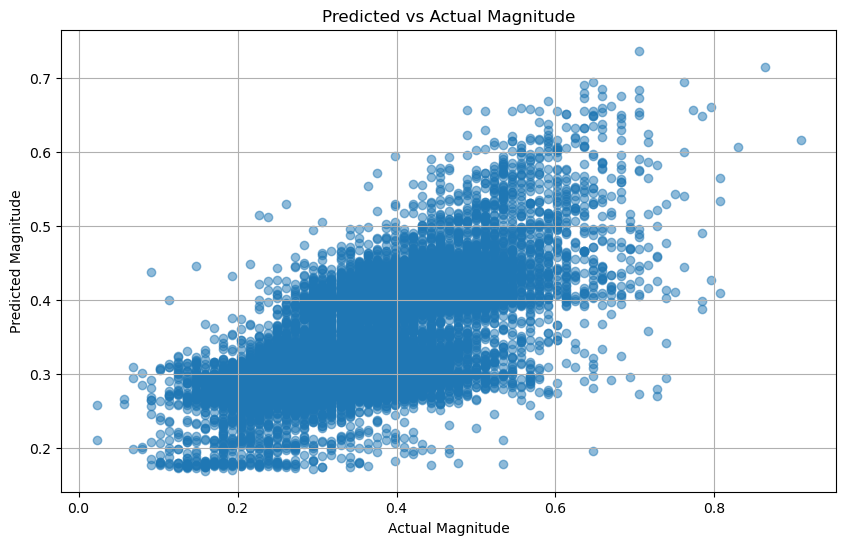

In [34]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Actual Magnitude")
plt.ylabel("Predicted Magnitude")
plt.title("Predicted vs Actual Magnitude")
plt.grid()
plt.show()


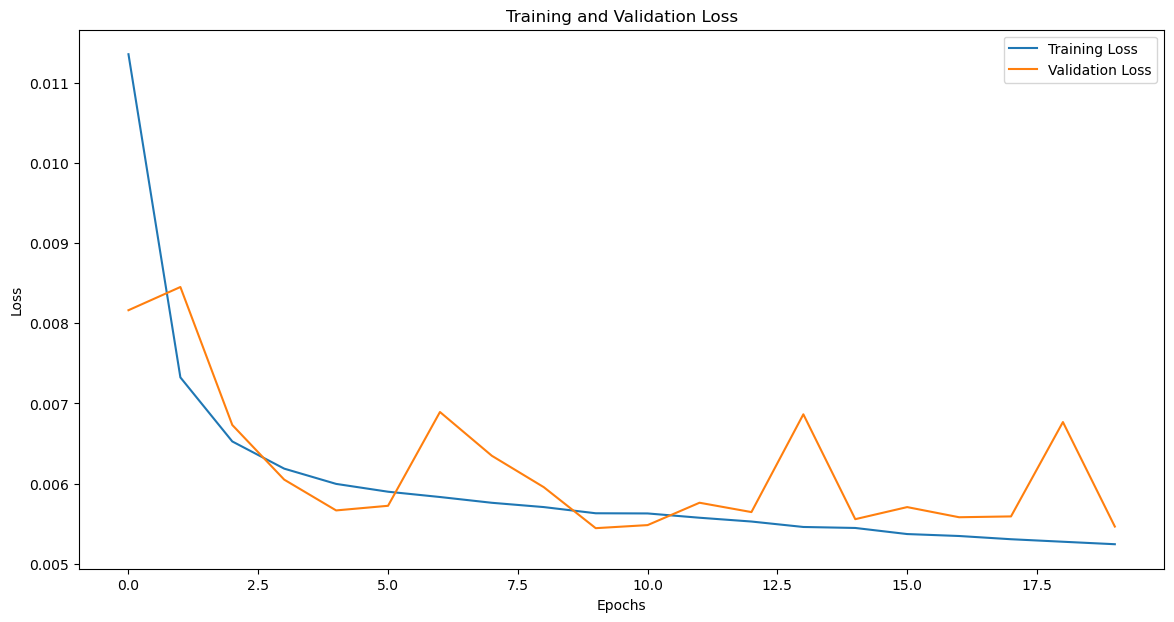

In [35]:
# Plot the training history
plt.figure(figsize=(14, 7))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


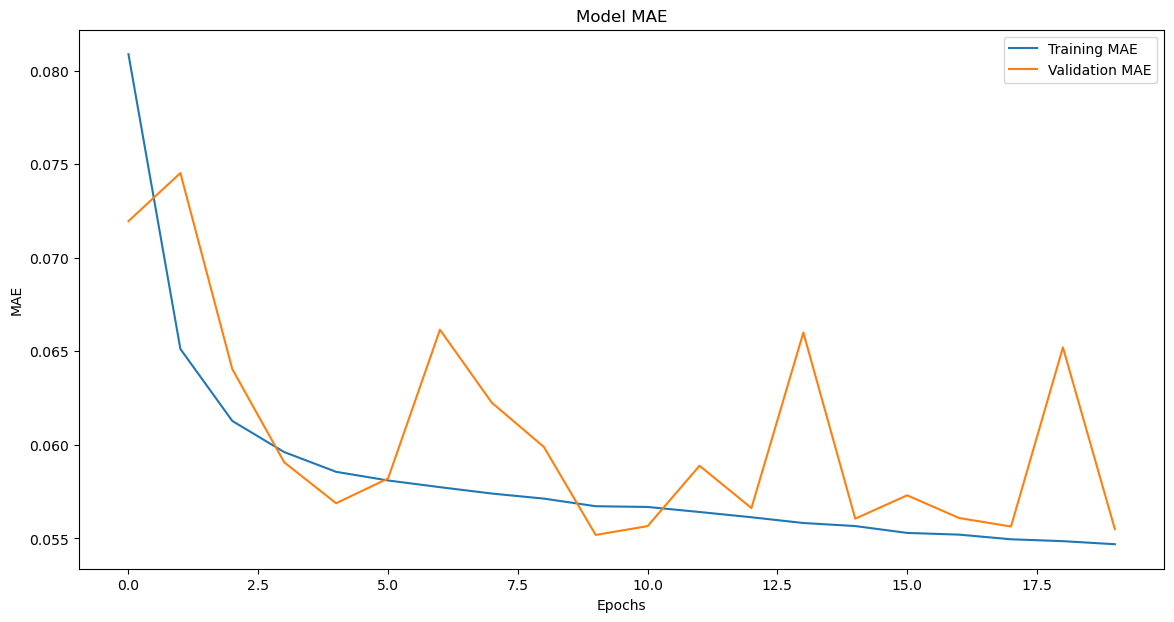

In [42]:
# Plot Training and Validation MAE
plt.figure(figsize=(14, 7))
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

In [37]:
# Save the model
model.save("cnn_bilstm_jma.h5")

C:\ProgramData\anaconda3\envs\skripsi\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
